# Previsões de série temporal: COVID-19

> https://cursos.alura.com.br/course/previsoes-serie-temporal-covid-19/

In [1]:
import sys
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm_api
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

sys.path.append(os.path.join(os.path.dirname(sys.path[0]), 'utils'))
from utils import Utils

DATA_PATH = "../data/covid.csv"

## Reading and processing

In [2]:
df = pd.read_csv(DATA_PATH)
df.rename(
    columns={
        'data': 'date',
        'estado': 'state',
        'novosObitos': 'newDeaths', 
        'Casos': 'cases'
    }, 
    inplace=True
)
df['date'] = pd.to_datetime(df['date']).dt.date
df.head()

,semana,date,pais,state,cidade,newDeaths,Obitos,novosCasos,cases,obitosMS,casosMS,obitos_por_100k,casos_por_100k,obitos_por_casos,recuperados,suspeitos,testes,testes_por_100k
0,9,2020-02-25,Brazil,SP,TOTAL,0,0,1,1,0,0,0.0,0.00218,0.0,NaN,NaN,NaN,NaN
1,9,2020-02-25,Brazil,TOTAL,TOTAL,0,0,1,1,0,0,0.0,0.00048,0.0,NaN,NaN,NaN,NaN
2,9,2020-02-26,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN
3,9,2020-02-26,Brazil,TOTAL,TOTAL,0,0,0,1,0,1,0.0,0.00048,0.0,NaN,NaN,NaN,NaN
4,9,2020-02-27,Brazil,SP,TOTAL,0,0,0,1,0,1,0.0,0.00218,0.0,NaN,NaN,NaN,NaN


## Analyzing São Paulo 

In [3]:
dfsp = df[df['state'] == 'SP']
dfsp.index = pd.to_datetime(dfsp['date']) #setting date to be the index
dfsp.tail()

,semana,date,pais,state,cidade,newDeaths,Obitos,novosCasos,cases,obitosMS,casosMS,obitos_por_100k,casos_por_100k,obitos_por_casos,recuperados,suspeitos,testes,testes_por_100k
date,,,,,,,,,,,,,,,,,,
2020-07-27,31,2020-07-27,Brazil,SP,TOTAL,70,21676,3672,487654,21676,487654,47.20481,1061.98628,0.04445,337434.0,333078.0,1158851.0,2523.68249
2020-07-28,31,2020-07-28,Brazil,SP,TOTAL,383,22059,12647,500301,21676,487654,48.03889,1089.52823,0.04409,337434.0,334977.0,1158851.0,2523.68249
2020-07-29,31,2020-07-29,Brazil,SP,TOTAL,330,22389,13896,514197,22389,514197,48.75754,1119.79018,0.04354,344501.0,340112.0,1158851.0,2523.68249
2020-07-30,31,2020-07-30,Brazil,SP,TOTAL,321,22710,14809,529006,22710,529006,49.45660,1152.04041,0.04293,349287.0,340112.0,1788225.0,3894.29886
2020-07-31,31,2020-07-31,Brazil,SP,TOTAL,287,22997,13298,542304,22997,542304,50.08161,1181.00007,0.04241,351610.0,340112.0,1788225.0,3894.29886


In [4]:
dec = seasonal_decompose(dfsp['newDeaths'], period=7) #data is updated weekly

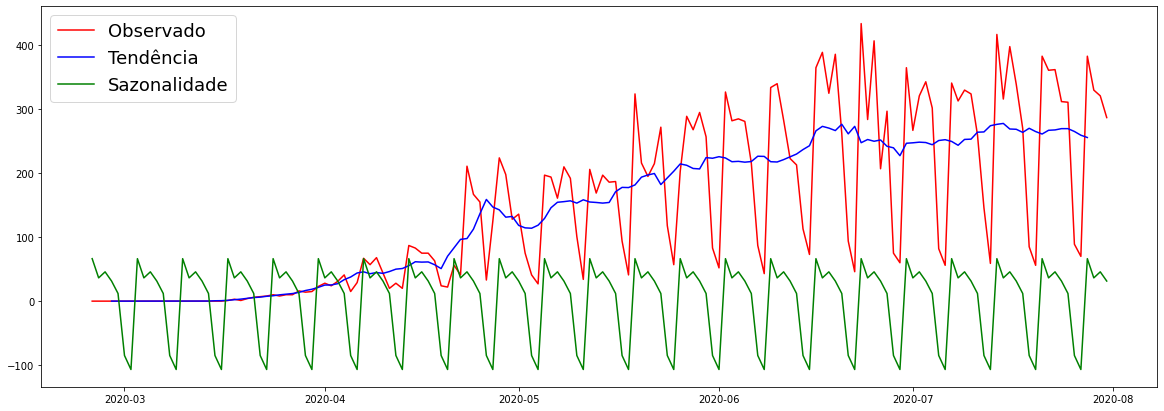

In [5]:
ys = [dec.observed, dec.trend, dec.seasonal]
colors = ["red", "blue", "green"]
labels = ["Observado", "Tendência", "Sazonalidade"]
Utils.plot_many_lines(ys, colors, labels)

## Comparing some states

In [6]:
dfmg = df[df['state'] == 'MG']
dfrj = df[df['state'] == 'RJ']
dfsp = df[df['state'] == 'SP']
dfsp.index = pd.to_datetime(dfsp['date'])
dfmg.index = pd.to_datetime(dfmg['date'])
dfrj.index = pd.to_datetime(dfrj['date'])
decmg = seasonal_decompose(dfmg['newDeaths'], period=7)
decrj = seasonal_decompose(dfrj['newDeaths'], period=7)
decsp = seasonal_decompose(dfsp['newDeaths'], period=7)

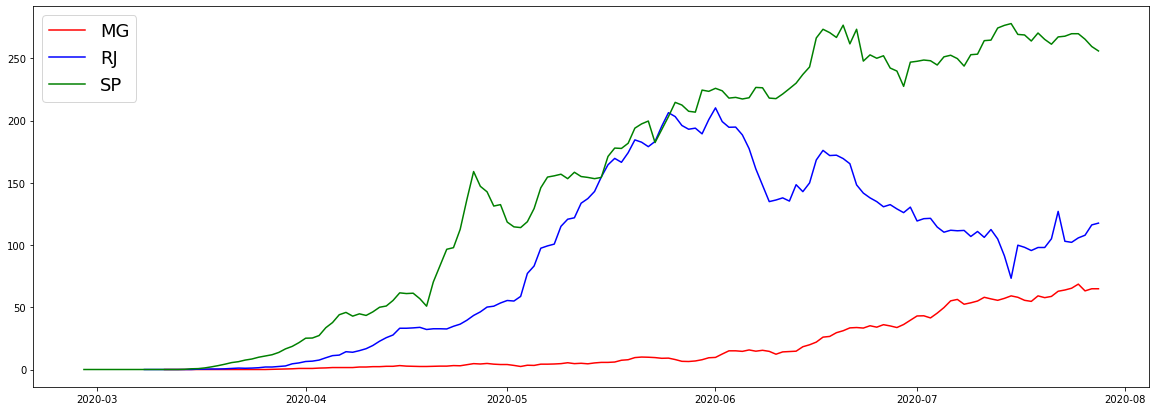

In [7]:
ys = [decmg.trend, decrj.trend, decsp.trend]
colors = ["red", "blue", "green"]
labels = ["MG", "RJ", "SP"]
Utils.plot_many_lines(ys, colors, labels)

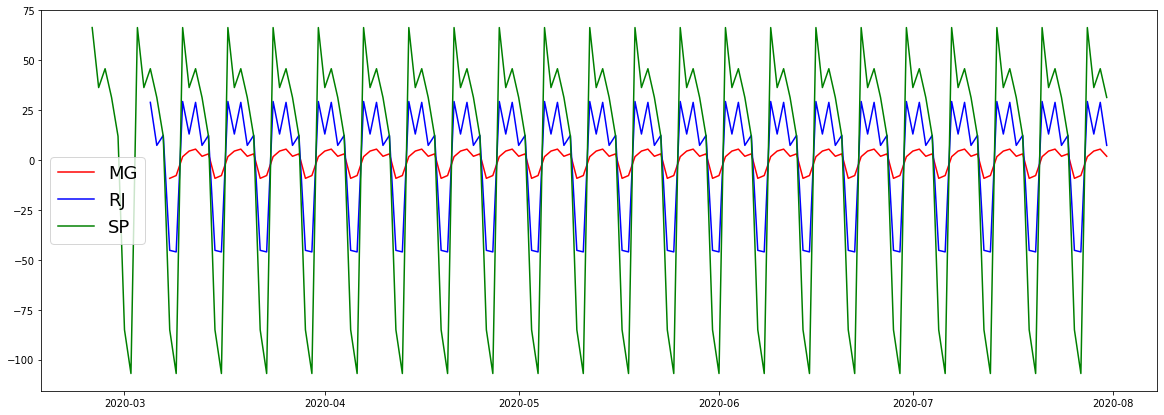

In [8]:
ys = [decmg.seasonal, decrj.seasonal, decsp.seasonal]
colors = ["red", "blue", "green"]
labels = ["MG", "RJ", "SP"]
Utils.plot_many_lines(ys, colors, labels)

## Testing ARIMA to predict cases

### ADF test and some analysis

In [9]:
y = dfsp['cases']
ret = adfuller(y.dropna())
ret

(1.3664743612803476,
 0.9969563888815705,
 14,
 143,
 {'1%': -3.4769274060112707,
  '5%': -2.8819726324025625,
  '10%': -2.577665408088415},
 2627.7242380318335)

In [10]:
"p-value {} from ADF teste is so high, then there are no evidences to reject H0 -> this time series is stationary".format(
    round(ret[1], 3)
)

'p-value 0.997 from ADF teste is so high, then there are no evidences to reject H0 -> this time series is stationary'

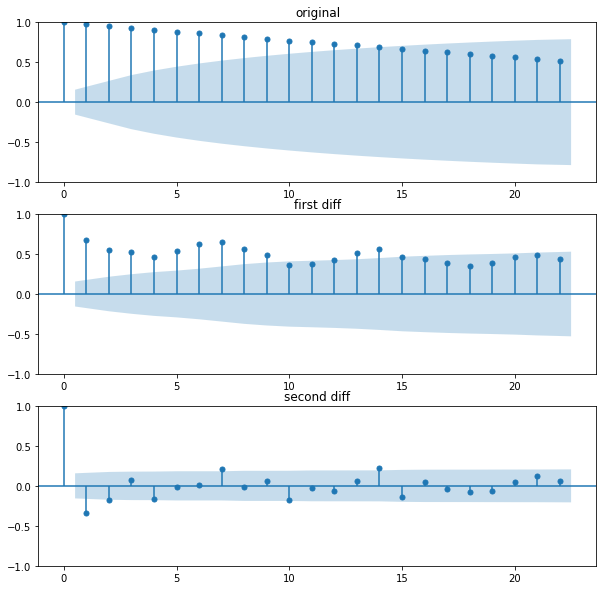

In [11]:
Utils.plot_two_diffs_ACF(y, y.diff().dropna(), y.diff().dropna().diff().dropna())

> * Second diff is really different from the first onde, raising a negative value

> * Seems smart to check the diffs graph:

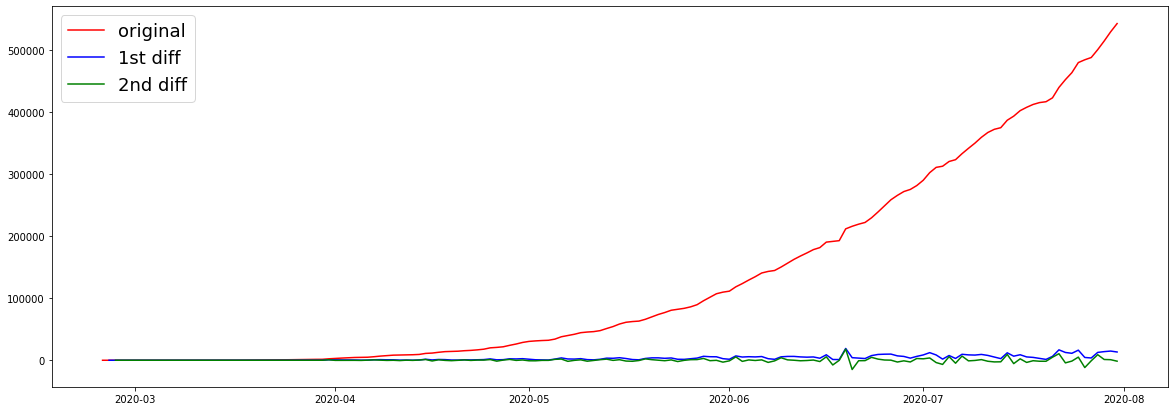

In [12]:
ys = [y, y.diff().dropna(), y.diff().dropna().diff().dropna()]
colors = ["red", "blue", "green"]
labels = ["original", "1st diff", "2nd diff"]
Utils.plot_many_lines(ys, colors, labels)

> * This is a sign of over-differentiation. That is, in the same way as in the classic models, where we can make a very complex model that generates overfitting, here we can end up over-differentiating

> * ARIMA is a combination of Auto-Regressive (AR), Moving Average (MA, Moving Average) and I, which is the degree of differentiation. That is, we need to know very well what degree of differentiation to use, to avoid over-differentiation.

> * Seems good to take a look at the partial autocorrelation graph



/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


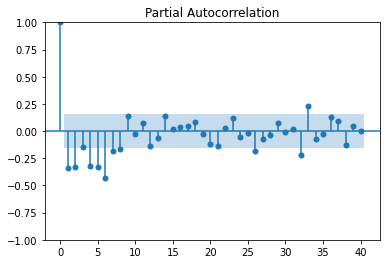

In [13]:
plot_pacf(y.diff().dropna().diff().dropna(), lags=40);

> * An observation is that our time series, in this case, is seasonal, so the right thing would be to use SARIMA (seasonal ARIMA)

> * ARIMA is modeled by three parameters, p (previous steps for AR using DATA), q (previous steps for MA with RESIDUALS) and d (degree of differentiation)



/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


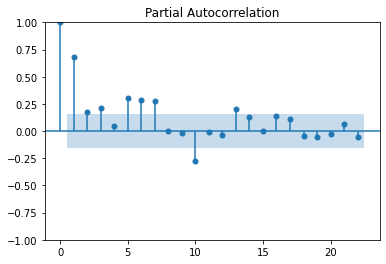

In [14]:
plot_pacf(y.diff().dropna());

> * We can be conservative and adopt d = 1

> * For the purposes of the example let's adopt p = q = d = 1

### ARIMA itself

In [15]:
model = ARIMA(y, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                  cases   No. Observations:                  158
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1456.914
Date:                Tue, 26 Oct 2021   AIC                           2919.828
Time:                        11:43:59   BIC                           2928.997
Sample:                    02-25-2020   HQIC                          2923.552
                         - 07-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.005    182.290      0.000       0.989       1.011
ma.L1         -0.8471      0.035    -24.151      0.000      -0.916      -0.778
sigma2      6.673e+06   2.04e-09   3.28e+15      0.0

## Automatic SARIMA

> * As seen, defining p, q and d can be a hard task, so the usual strategy is to build a kind of grid search over these parameters, evaluating a metric such as AIC or BIC

In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [17]:
#"7" is used because data is weekly updated

seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]
seasonal_pdq

[(0, 0, 0, 7),
 (0, 0, 1, 7),
 (0, 1, 0, 7),
 (0, 1, 1, 7),
 (1, 0, 0, 7),
 (1, 0, 1, 7),
 (1, 1, 0, 7),
 (1, 1, 1, 7)]

In [18]:
y = dfsp['cases']
y

date
2020-02-25         1
2020-02-26         1
2020-02-27         1
2020-02-28         2
2020-02-29         2
               ...  
2020-07-27    487654
2020-07-28    500301
2020-07-29    514197
2020-07-30    529006
2020-07-31    542304
Name: cases, Length: 158, dtype: int64

In [19]:
AICs = list()
for arima_param in pdq:
    for sarima_param in seasonal_pdq:
        model = sm_api.tsa.statespace.SARIMAX(
            y,
            order=arima_param, #SARIMA non-seasonal parameters
            seasonal_order=sarima_param, #SARIMA seasonal parameters
        )
        results = model.fit()
        AICs.append((arima_param, sarima_param, results.aic))

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarim

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36399D+01    |proj g|=  3.55272D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.553D-10   1.364D+01
  F =   13.639887542360468     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.3

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarim

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     13      1     0     0   3.621D-06   1.329D+01
  F =   13.289990991000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36400D+01    |proj g|=  9.52503D-01

At iterate    5    f=  1.32307D+01    |proj g|=  4.65646D-03

At iterate   10    f=  1.32297D+01    |proj g|=  4.32295D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.p

Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.196D-06   9.933D+00
  F =   9.9326715992247507     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86526D+00    |proj g|=  4.29766D-01

At iterate    5    f=  9.76054D+00    |proj g|=  4.83229D-04

At iterate   10    f=  9.76054D+00    |proj g|=  1.06540D-03

At iterate   15    f=  9.76004D+00    |proj g|=  1.52719D-02

At iterate   20    f=  9.69703D+00    |proj g|=  2.14545D-01

At iterate   25    f=  9.65601D+00    |proj 

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.p

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66194D+00    |proj g|=  2.34422D-01

At iterate    5    f=  9.62143D+00    |proj g|=  3.06784D-04

At iterate   10    f=  9.62131D+00    |proj g|=  5.97502D-03

At iterate   15    f=  9.60739D+00    |proj g|=  6.19283D-02

At iterate   20    f=  9.49015D+00    |proj g|=  5.29753D-02

At iterate   25    f=  9.48409D+00    |proj g|=  1.38479D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     29      1     0     0   1.385D-05   9.484D+00
  F =   9.4840894021325060     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/s

Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     31     32      1     0     0   8.797D-06   1.003D+01
  F =   10.034452076288348     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09155D+03    |proj g|=  6.02424D+03

At iterate    5    f=  4.29178D+01    |proj g|=  5.53221D+01

At iterate   10    f=  1.32120D+01    |proj g|=  2.41291D+00

At iterate   15    f=  1.04515D+01    |proj g|=  1.30432D-01

At iterate   20    f=  1.00468D+01    |proj g|=  2.56851D-02

At iterate   25    f=  9.99692D+00    |proj g|=  4.75061D-03

At iterate   30    f=  9.93872D+00    |proj g|=  1.16871D-01

At iterate   35    f=  9

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/s

At iterate   20    f=  8.91571D+00    |proj g|=  1.73051D-03

At iterate   25    f=  8.82305D+00    |proj g|=  4.19766D-02

At iterate   30    f=  8.82130D+00    |proj g|=  3.45062D-03

At iterate   35    f=  8.81996D+00    |proj g|=  1.00274D-03

At iterate   40    f=  8.81976D+00    |proj g|=  1.92492D-04

At iterate   45    f=  8.81721D+00    |proj g|=  4.16117D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     76      1     0     0   1.741D-04   8.811D+00
  F =   8.8111594554377035     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/l/disk0/iaraujo/.local/lib/pytho

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     39      1     0     0   2.420D-05   9.302D+00
  F =   9.3022785212024672     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19906D+01    |proj g|=  1.50621D+02

At iterate    5    f=  9.75923D+00    |proj g|=  6.66951D-01

At iterate   10    f=  9.00463D+00    |proj g|=  3.72626D-01

At iterate   15    f=  8.88748D+00    |proj g|=  7.24361D-02

At iterate   20    f=  8.8

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.p

F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     42      1     0     0   1.806D-06   9.194D+00
  F =   9.1941761993529365     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77340D+00    |proj g|=  6.15002D-02

At iterate    5    f=  8.77084D+00    |proj g|=  6.87990D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/l/disk0/iaraujo/.local/lib/python3.8/s

In [20]:
sorted(AICs, key=lambda x: x[-1])

[((1, 1, 1), (0, 1, 1, 7), 2748.2912728042456),
 ((1, 1, 1), (1, 1, 1, 7), 2749.7868548631204),
 ((1, 1, 1), (1, 1, 0, 7), 2768.803123034122),
 ((1, 1, 0), (1, 1, 1, 7), 2771.790262047888),
 ((0, 1, 1), (0, 1, 1, 7), 2772.4295190414514),
 ((0, 1, 0), (0, 1, 1, 7), 2773.045713249749),
 ((0, 1, 0), (1, 1, 0, 7), 2773.627897309136),
 ((0, 1, 0), (1, 1, 1, 7), 2774.287684079679),
 ((1, 1, 0), (0, 1, 1, 7), 2776.1979187753495),
 ((0, 1, 1), (1, 1, 1, 7), 2776.943873850594),
 ((1, 1, 0), (1, 1, 0, 7), 2777.5863909966965),
 ((0, 1, 1), (1, 1, 0, 7), 2778.098082280269),
 ((1, 0, 0), (1, 1, 1, 7), 2792.326387918314),
 ((1, 0, 1), (0, 1, 1, 7), 2792.405536920339),
 ((1, 0, 0), (0, 1, 1, 7), 2792.936555884011),
 ((1, 0, 0), (1, 1, 0, 7), 2793.407955104035),
 ((1, 0, 1), (1, 1, 0, 7), 2794.0213766348033),
 ((0, 1, 0), (0, 1, 0, 7), 2802.474674572399),
 ((1, 1, 1), (0, 1, 0, 7), 2803.0662242950852),
 ((1, 1, 0), (0, 1, 0, 7), 2804.4546833407167),
 ((0, 1, 1), (0, 1, 0, 7), 2804.4967826068955),
 ((1

> * The best model might be the one with lower AIC, so p = d = q = 1 and P = 0, Q = D = 1

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


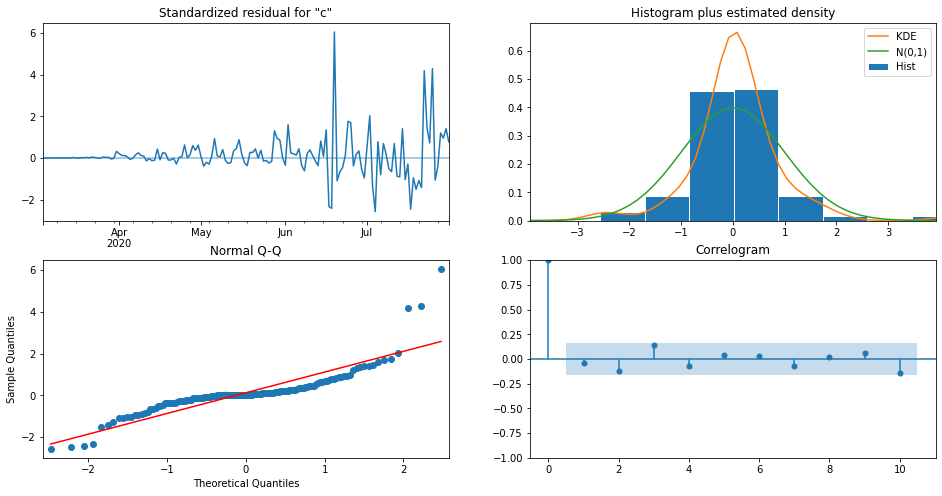

In [21]:
best_model = sm_api.tsa.statespace.SARIMAX(
    y,
    order=(1, 1, 1), #(p, d, q)
    seasonal_order=(0, 1, 1, 7) #(P, D, Q, periodicity)
)
result = best_model.fit()
result.plot_diagnostics(figsize=(16, 8))
plt.show()

In [22]:
pred = results.get_prediction(start=pd.to_datetime('2020-07-01'), dynamic=False)
pred_ic = pred.conf_int()
pred_ic

,lower cases,upper cases
2020-07-01,284123.514104,292788.148816
2020-07-02,293087.155546,301751.787832
2020-07-03,309712.894649,318377.524823
2020-07-04,313808.509344,322473.137680
2020-07-05,314049.636427,322714.263164
2020-07-06,320494.634933,329159.260279
2020-07-07,327045.769133,335710.394316
2020-07-08,336585.455559,345250.079518
2020-07-09,346345.218970,355009.841730
2020-07-10,356625.564499,365290.186215


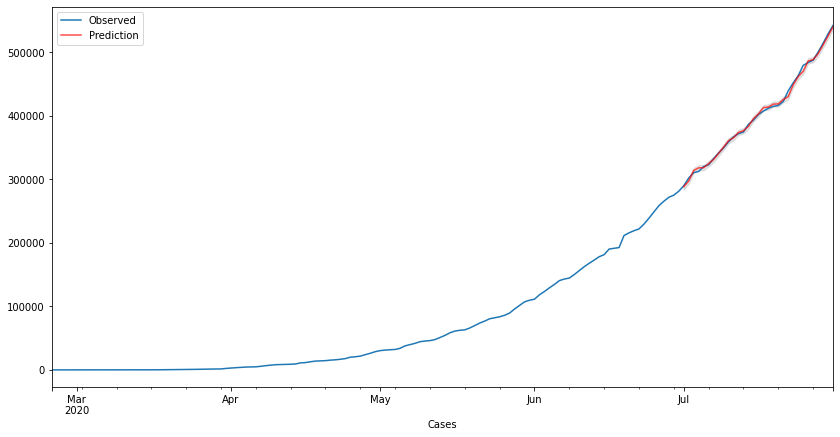

In [23]:
ax = y['2020':].plot(label="Observed")
pred.predicted_mean.plot(ax=ax, label="Prediction", color="r", alpha=0.7, figsize=(14, 7))
ax.fill_between(pred_ic.index, pred_ic.iloc[:, 0], pred_ic.iloc[:, 1], color='k', alpha=0.1)
ax.set_xlabel("Date")
ax.set_xlabel("Cases")
plt.legend()
plt.show()

### Building predictions and confidence intervals on unseen data

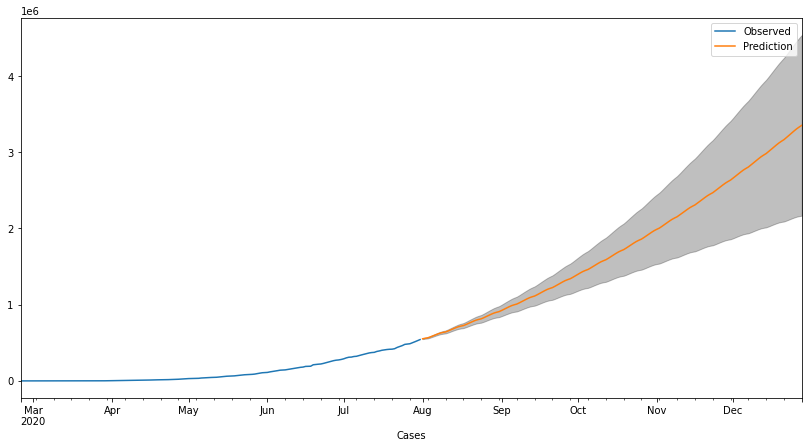

In [24]:
pred_uc = results.get_forecast(steps=150)
pred_ic = pred_uc.conf_int()
ax = y.plot(label="Observed", figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label="Prediction")
ax.fill_between(pred_ic.index, pred_ic.iloc[:,0], pred_ic.iloc[:,1], color='k', alpha=0.25)
ax.set_xlabel("Date")
ax.set_xlabel("Cases")
plt.legend()
plt.show()

In [27]:
dfy = pd.DataFrame(y).reset_index()
ytrain = dfy[dfy['date'] < pd.to_datetime('2020-07-01')]['cases']
ytest = dfy[dfy['date'] >= pd.to_datetime('2020-07-01')]['cases']
ytest

127    289935
128    302179
129    310702
130    312530
131    320179
132    323070
133    332708
134    341365
135    349715
136    359110
137    366890
138    371997
139    374607
140    386607
141    393176
142    402048
143    407415
144    412027
145    415049
146    416434
147    422669
148    439446
149    452007
150    463218
151    479481
152    483982
153    487654
154    500301
155    514197
156    529006
157    542304
Name: cases, dtype: int64

/l/disk0/iaraujo/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


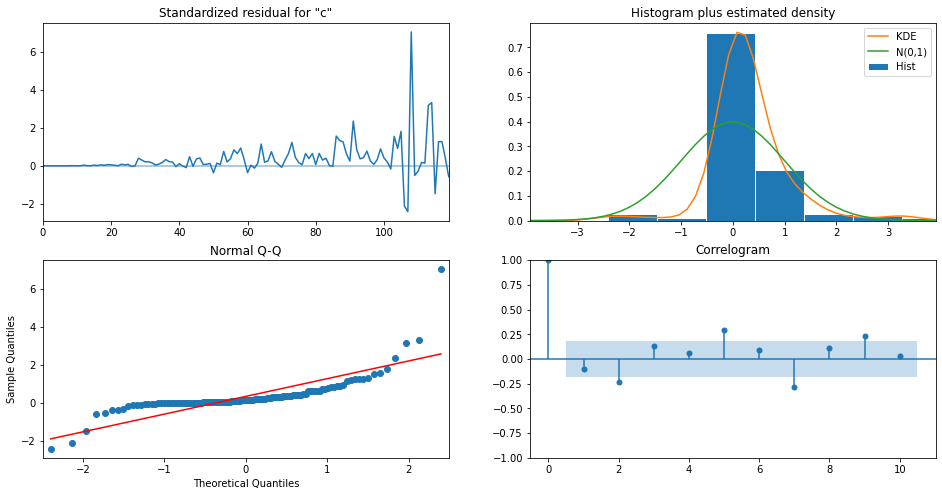

In [28]:
best_model = sm_api.tsa.statespace.SARIMAX(
    ytrain,
    orde =(1, 1, 1),
    seasonal_order=(0, 1, 1, 7)
)
result = best_model.fit()
result.plot_diagnostics(figsize=(16, 8))
plt.show()

In [29]:
pred = result.get_prediction(start=127, dynamic=False)
pred_ic = pred.conf_int()
for i in range(128, 158):
    pred = result.get_prediction(start=i, dynamic=False)
    pred_ic = pd.concat([pred_ic, pred.conf_int()])
pred_ic

,lower cases,upper cases
127,284067.243856,291762.175370
128,289299.495318,300181.771596
129,299294.487146,312622.498924
130,304213.427944,319603.289992
131,308331.134256,325537.522743
132,310569.296191,329417.950006
133,316562.693416,336921.565965
134,321480.104532,345073.570225
135,326885.161715,353320.356878
136,336820.725129,365820.508767


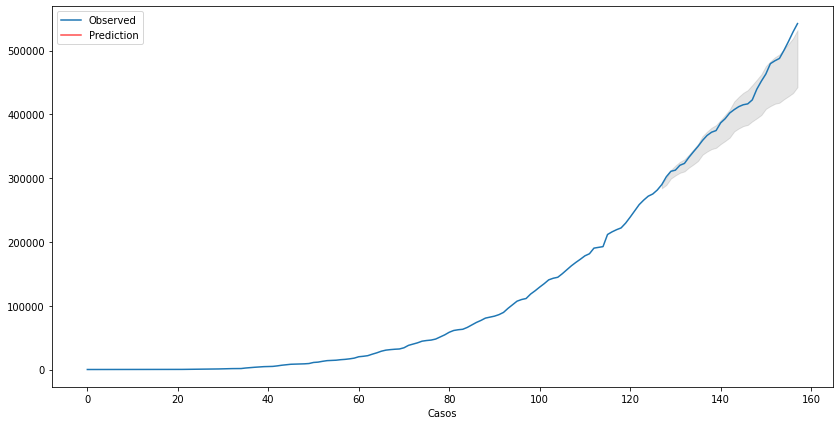

In [30]:
ax = pd.concat([ytrain, ytest]).plot(label="Observed")
pred.predicted_mean.plot(ax=ax, label="Prediction", color="r", alpha=0.7, figsize=(14, 7))
ax.fill_between(pred_ic.index, pred_ic.iloc[:, 0], pred_ic.iloc[:, 1], color='k', alpha = 0.1)
ax.set_xlabel("Data")
ax.set_xlabel("Casos")
plt.legend()
plt.show()